# Web Scraping and Text Analysis demo project

In this project, we will perform web scraping on a web to extract text from more than 1,000 different links and store the words in the text in two different lists for text-analysis.

The data source chosen is the Spanish version of the Bible hosted in the Vatican website.
We will use Requests, lxml, re, advertools, and word_cloud to clean the data, remove non-alphabetic characters without removing the Spanish accents, and identify the most frequent words in the two main parts of the text.

## Libraries installation and loading

In [1]:
# install requests, lxml & word_cloud
! pip install requests
! pip install lxml
! pip install wordcloud
! pip install advertools

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# load dependencies
import requests # handles HTTP requests
import lxml.html # for web scraping
import re # to use regular expressions
from wordcloud import WordCloud # to build word clouds
import advertools as adv # contains stopwords for several languages
import matplotlib.pyplot as plt # for plotting the word cloud

## HTML inspection

Let us inspect the HTML of a sample chapter in the Spanish Bible to extract the verses from the HTML tags

In [3]:
sample_url = "https://www.vatican.va/archive/ESL0506/__P4.HTM"
sample_response = requests.get(sample_url)
url_content = sample_response.content

In [4]:
# print the HTTP request status code
print(sample_response.status_code)

200


In [5]:
sample_html = lxml.html.fromstring(url_content)
# Each verse is wrapped inside <p class="MsoNormal"></p> tags
# we extract the verses using the xpath function
sample_verses = sample_html.xpath("//p[contains(@class, 'MsoNormal')]")
# let us print the number of p tags containing verses in this chapter
len(sample_verses)

29

We see there are 29 p tags for 24 verses in this chapter. Thus, some verses are split into more than one p tag.

Let us now check the content of a single p tag and determine a way of extracting each word

In [6]:
# example verse taken from the book of Genesis
# once more, we use xpath() to extract properties from the p tags for each verse
proto_evangelium = sample_verses[17].xpath("text()")[0]
sample_verse_text = str(proto_evangelium)
# replace spanish accents to their non-accent version, and non-printable characters for spaces
sample_verse_text = sample_verse_text.replace("\n"," ")
sample_verse_text = sample_verse_text.replace("á","a")
sample_verse_text = sample_verse_text.replace("é","e")
sample_verse_text = sample_verse_text.replace("í","i")
sample_verse_text = sample_verse_text.replace("ó","o")
sample_verse_text = sample_verse_text.replace("ú","u")
# use regular expressions to replace non-alphabetic characters for spaces
sample_verse_text = re.sub(r'[–.,:;()¿?¡!«»0-9]+', ' ', sample_verse_text)
sample_verse_text = sample_verse_text.rsplit(" ")
# let us print the list of words for this verse
print(sample_verse_text)

['', '', 'Pondre', 'enemistad', 'entre', 'ti', 'y', 'la', 'mujer', '', 'entre', 'tu', 'linaje', 'y', 'el', 'suyo', '', 'El', 'te', 'aplastara', 'la', 'cabeza', 'y', 'tu', 'le', 'acecharas', 'el', 'talon', '']


Before moving on from the sample chapter, let us learn how to extract the book name from the chapter page

In [7]:
book_tag = "//font[contains(@face,'Verdana')]//ul[contains(@type,'square')]//ul[contains(@type,'square')]//li/text()"
sample_book_name = sample_html.xpath(book_tag)[0]
str(sample_book_name)

'GENESIS'

## Retrieving the entire data

Now that we know how to extract the book name and list of words for a chapter, let us start by extracting the links for each chapter from the index page

In [8]:
index_url = "https://www.vatican.va/archive/ESL0506/_INDEX.HTM"
response = requests.get(index_url)
content = response.content
print(response.status_code)

200


In [9]:
html = lxml.html.fromstring(content)
books_tag = "//ul[contains(@type, 'square')]"
books = html.xpath(books_tag)
len(books)

73

Things look good, since there are a total of 73 books in the Catholic Spanish Bible

In [10]:
chapter_tag = ".//li//font[contains(@size,'2')]//a/@href"
chapters = books[0].xpath(chapter_tag)
# number of chapters
len(chapters)

1329

Let us have a look at the chapter links relative to the main URL

In [11]:
print(chapters[0:10])

['__P2.HTM', '__P3.HTM', '__P4.HTM', '__P5.HTM', '__P6.HTM', '__P7.HTM', '__P8.HTM', '__P9.HTM', '__PA.HTM', '__PB.HTM']


Now, we loop throught each chapter and populate temporal variables

In [12]:
# end of the Old Testament
chapters.index('__PUA.HTM')

1072

In [13]:
ot_words = []

# chapters loop for the Old Testament
# takes a few minutes... please be patient
for chapter in chapters[0:1073]:
    chapter_url = f"https://www.vatican.va/archive/ESL0506/{chapter}"
    chapter_response = requests.get(chapter_url)
    chapter_content = chapter_response.content
    chapter_html = lxml.html.fromstring(chapter_content)
    book_tag = "//font[contains(@face,'Verdana')]//ul[contains(@type,'square')]//ul[contains(@type,'square')]//li/text()"
    book_name = chapter_html.xpath(book_tag)[0]
    chapter_verses = chapter_html.xpath("//p[contains(@class, 'MsoNormal')]")
    # the book names and chapter relative links are printed as progress indicator and for debugging purposes
    print(book_name + "/" + chapter)
    for i in range(0, len(chapter_verses)):
        # if condition to handle exception p tags that contain no verse (used for section titles)
        if (chapter=='__P5C.HTM' and i==14) or (chapter=='__P8N.HTM' and i in [36,37]) or (chapter=='__PAN.HTM' and i in [11,12]) or (chapter=='__PB5.HTM' and i in [16,17]) or (chapter=='__PUA.HTM' and i == 42):
            verse_text = ['']
        else:
            verse_text = chapter_verses[i].xpath("text()")[0]
            # parse to string the text of the verse
            verse_text = str(verse_text)
            # remove line breaks
            verse_text = verse_text.replace("\n"," ")
            # remove Spanish accents
            verse_text = verse_text.replace("á","a")
            verse_text = verse_text.replace("é","e")
            verse_text = verse_text.replace("í","i")
            verse_text = verse_text.replace("ó","o")
            verse_text = verse_text.replace("ú","u")
            # use regular expressions to replace non-alphabetic characters for spaces
            verse_text = re.sub(r'[–.,:;()¿?¡!«»0-9]+', ' ', verse_text)
            verse_text = verse_text.split(" ")
        for word_j in range(0, len(verse_text)):
            if verse_text[word_j] != '':
                ot_words.append(verse_text[word_j])

GENESIS/__P2.HTM
GENESIS/__P3.HTM
GENESIS/__P4.HTM
GENESIS/__P5.HTM
GENESIS/__P6.HTM
GENESIS/__P7.HTM
GENESIS/__P8.HTM
GENESIS/__P9.HTM
GENESIS/__PA.HTM
GENESIS/__PB.HTM
GENESIS/__PC.HTM
GENESIS/__PD.HTM
GENESIS/__PE.HTM
GENESIS/__PF.HTM
GENESIS/__PG.HTM
GENESIS/__PH.HTM
GENESIS/__PI.HTM
GENESIS/__PJ.HTM
GENESIS/__PK.HTM
GENESIS/__PL.HTM
GENESIS/__PM.HTM
GENESIS/__PN.HTM
GENESIS/__PO.HTM
GENESIS/__PP.HTM
GENESIS/__PQ.HTM
GENESIS/__PR.HTM
GENESIS/__PS.HTM
GENESIS/__PT.HTM
GENESIS/__PU.HTM
GENESIS/__PV.HTM
GENESIS/__PW.HTM
GENESIS/__PX.HTM
GENESIS/__PY.HTM
GENESIS/__PZ.HTM
GENESIS/__P10.HTM
GENESIS/__P11.HTM
GENESIS/__P12.HTM
GENESIS/__P13.HTM
GENESIS/__P14.HTM
GENESIS/__P15.HTM
GENESIS/__P16.HTM
GENESIS/__P17.HTM
GENESIS/__P18.HTM
GENESIS/__P19.HTM
GENESIS/__P1A.HTM
GENESIS/__P1B.HTM
GENESIS/__P1C.HTM
GENESIS/__P1D.HTM
GENESIS/__P1E.HTM
GENESIS/__P1F.HTM
EXODO/__P1H.HTM
EXODO/__P1I.HTM
EXODO/__P1J.HTM
EXODO/__P1K.HTM
EXODO/__P1L.HTM
EXODO/__P1M.HTM
EXODO/__P1N.HTM
EXODO/__P1O.HTM
EXODO/

ISAIAS/__PAC.HTM
ISAIAS/__PAD.HTM
ISAIAS/__PAE.HTM
ISAIAS/__PAF.HTM
ISAIAS/__PAG.HTM
ISAIAS/__PAH.HTM
ISAIAS/__PAI.HTM
ISAIAS/__PAJ.HTM
ISAIAS/__PAK.HTM
ISAIAS/__PAL.HTM
ISAIAS/__PAM.HTM
ISAIAS/__PAN.HTM
ISAIAS/__PAO.HTM
ISAIAS/__PAR.HTM
ISAIAS/__PAS.HTM
ISAIAS/__PAT.HTM
ISAIAS/__PAU.HTM
ISAIAS/__PAV.HTM
ISAIAS/__PAW.HTM
ISAIAS/__PAX.HTM
ISAIAS/__PAY.HTM
ISAIAS/__PAZ.HTM
ISAIAS/__PB0.HTM
ISAIAS/__PB1.HTM
ISAIAS/__PB2.HTM
ISAIAS/__PB3.HTM
ISAIAS/__PB4.HTM
ISAIAS/__PB5.HTM
ISAIAS/__PB6.HTM
ISAIAS/__PB7.HTM
ISAIAS/__PB8.HTM
ISAIAS/__PB9.HTM
ISAIAS/__PBA.HTM
ISAIAS/__PBB.HTM
ISAIAS/__PBC.HTM
ISAIAS/__PBD.HTM
ISAIAS/__PBE.HTM
ISAIAS/__PBF.HTM
ISAIAS/__PBG.HTM
JEREMIAS/__PBH.HTM
JEREMIAS/__PBI.HTM
JEREMIAS/__PBJ.HTM
JEREMIAS/__PBK.HTM
JEREMIAS/__PBL.HTM
JEREMIAS/__PBM.HTM
JEREMIAS/__PBN.HTM
JEREMIAS/__PBO.HTM
JEREMIAS/__PBP.HTM
JEREMIAS/__PBQ.HTM
JEREMIAS/__PBR.HTM
JEREMIAS/__PBS.HTM
JEREMIAS/__PBT.HTM
JEREMIAS/__PBU.HTM
JEREMIAS/__PBV.HTM
JEREMIAS/__PBW.HTM
JEREMIAS/__PBX.HTM
JEREMIAS/__PBY

ESTER/__PN8.HTM
ESTER/__PN9.HTM
ESTER/__PNA.HTM
ESTER/__PNB.HTM
ESTER/__PNC.HTM
ESTER/__PND.HTM
ESTER/__PNE.HTM
ESTER/__PNF.HTM
ESTER/__PNG.HTM
DANIEL/__PNH.HTM
DANIEL/__PNI.HTM
DANIEL/__PNJ.HTM
DANIEL/__PNK.HTM
DANIEL/__PNL.HTM
DANIEL/__PNM.HTM
DANIEL/__PNN.HTM
DANIEL/__PNO.HTM
DANIEL/__PNP.HTM
DANIEL/__PNQ.HTM
DANIEL/__PNR.HTM
DANIEL/__PNS.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNT.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNU.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNV.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNW.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNX.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNY.HTM
PRIMER LIBRO DE LAS CRONICAS/__PNZ.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO0.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO1.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO2.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO3.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO4.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO5.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO6.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO7.HTM
PRIMER LIBRO DE LAS CRONICAS/__PO8.HTM
PRIMER LIBRO DE LAS CRONICAS

In [14]:
# number of words found in the Old Testament
print(len(ot_words))

641002


In [15]:
nt_words = []

# chapters loop for the New Testament
# takes a few minutes... please be patient
for chapter in chapters[1073: len(chapters)]:
    chapter_url = f"https://www.vatican.va/archive/ESL0506/{chapter}"
    chapter_response = requests.get(chapter_url)
    chapter_content = chapter_response.content
    chapter_html = lxml.html.fromstring(chapter_content)
    book_tag = "//font[contains(@face,'Verdana')]//ul[contains(@type,'square')]//ul[contains(@type,'square')]//li/text()"
    book_name = chapter_html.xpath(book_tag)[0]
    chapter_verses = chapter_html.xpath("//p[contains(@class, 'MsoNormal')]")
    # the book names and chapter relative links are printed as progress indicator and for debugging purposes
    print(book_name + "/" + chapter)
    for i in range(0, len(chapter_verses)):
        # if condition to handle exception p tags that contain no verse (used for section titles)
        if (chapter=='__PUB.HTM' and i in [0,1]) or (chapter=='__P11I.HTM' and i in [22,23]):
            verse_text = ['']
        else:
            verse_text = chapter_verses[i].xpath("text()")[0]
            # parse to string the text of the verse
            verse_text = str(verse_text)
            # remove line breaks
            verse_text = verse_text.replace("\n"," ")
            # remove Spanish accents
            verse_text = verse_text.replace("á","a")
            verse_text = verse_text.replace("é","e")
            verse_text = verse_text.replace("í","i")
            verse_text = verse_text.replace("ó","o")
            verse_text = verse_text.replace("ú","u")
            # use regular expressions to replace non-alphabetic characters for spaces
            verse_text = re.sub(r'[–.,:;()¿?¡!«»0-9]+', ' ', verse_text)
            verse_text = verse_text.split(" ")
        for word_j in range(0, len(verse_text)):
            if verse_text[word_j] != '':
                nt_words.append(verse_text[word_j])

EVANGELIO SEGUN SAN MATEO/__PUB.HTM
EVANGELIO SEGUN SAN MATEO/__PUC.HTM
EVANGELIO SEGUN SAN MATEO/__PUD.HTM
EVANGELIO SEGUN SAN MATEO/__PUE.HTM
EVANGELIO SEGUN SAN MATEO/__PUF.HTM
EVANGELIO SEGUN SAN MATEO/__PUG.HTM
EVANGELIO SEGUN SAN MATEO/__PUH.HTM
EVANGELIO SEGUN SAN MATEO/__PUI.HTM
EVANGELIO SEGUN SAN MATEO/__PUJ.HTM
EVANGELIO SEGUN SAN MATEO/__PUK.HTM
EVANGELIO SEGUN SAN MATEO/__PUL.HTM
EVANGELIO SEGUN SAN MATEO/__PUM.HTM
EVANGELIO SEGUN SAN MATEO/__PUN.HTM
EVANGELIO SEGUN SAN MATEO/__PUO.HTM
EVANGELIO SEGUN SAN MATEO/__PUP.HTM
EVANGELIO SEGUN SAN MATEO/__PUQ.HTM
EVANGELIO SEGUN SAN MATEO/__PUR.HTM
EVANGELIO SEGUN SAN MATEO/__PUS.HTM
EVANGELIO SEGUN SAN MATEO/__PUT.HTM
EVANGELIO SEGUN SAN MATEO/__PUU.HTM
EVANGELIO SEGUN SAN MATEO/__PUV.HTM
EVANGELIO SEGUN SAN MATEO/__PUW.HTM
EVANGELIO SEGUN SAN MATEO/__PUX.HTM
EVANGELIO SEGUN SAN MATEO/__PUY.HTM
EVANGELIO SEGUN SAN MATEO/__PUZ.HTM
EVANGELIO SEGUN SAN MATEO/__PV0.HTM
EVANGELIO SEGUN SAN MATEO/__PV1.HTM
EVANGELIO SEGUN SAN MATEO/__

APOCALIPSIS/__P10X.HTM
APOCALIPSIS/__P10Y.HTM
APOCALIPSIS/__P10Z.HTM
APOCALIPSIS/__P110.HTM
APOCALIPSIS/__P111.HTM
APOCALIPSIS/__P112.HTM
APOCALIPSIS/__P113.HTM
APOCALIPSIS/__P114.HTM
APOCALIPSIS/__P115.HTM
APOCALIPSIS/__P116.HTM
APOCALIPSIS/__P117.HTM
APOCALIPSIS/__P118.HTM
APOCALIPSIS/__P119.HTM
APOCALIPSIS/__P11A.HTM
APOCALIPSIS/__P11B.HTM
APOCALIPSIS/__P11C.HTM
APOCALIPSIS/__P11D.HTM
APOCALIPSIS/__P11E.HTM
APOCALIPSIS/__P11F.HTM
APOCALIPSIS/__P11G.HTM
APOCALIPSIS/__P11H.HTM
APOCALIPSIS/__P11I.HTM


In [16]:
# number of words found in the New Testament
print(len(nt_words))

165912


In [17]:
# load stop words for the Spanish language
stopwords = adv.stopwords['spanish']
# include two basic stopwords missing from the advertools set for Spanish
stopwords.add('a')
stopwords.add('y')

In [18]:
# Old Testament word cloud
ot_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
separator = ' '

# generarates word cloud
ot_wc.generate(separator.join(ot_words))

In [19]:
# New Testament word cloud
nt_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
separator = ' '

# generarates word cloud
nt_wc.generate(separator.join(nt_words))

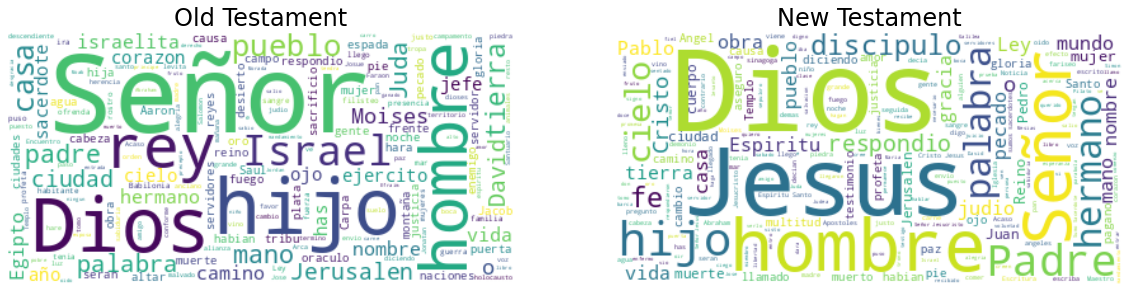

In [20]:
fig = plt.figure()
fig.set_figwidth(20) # set width
fig.set_figheight(18) # set height

# show word clouds
plt.subplot(121)
plt.imshow(ot_wc, interpolation='bilinear')
plt.title('Old Testament', fontdict={'fontsize':24})
plt.axis('off')
plt.subplot(122)
plt.imshow(nt_wc, interpolation='bilinear')
plt.title('New Testament', fontdict={'fontsize':24})
plt.axis('off')
plt.show()

## Conclusion

The differences in the word frequence illustrated in the diagrams above suggest that differences in context and grammatical styles in the two main parts of the Spanish Bible have an impact on the wording. However, further analysis pertains to a different discipline and is out of the scope of this sample project.